# Object detection
1 сценарий (разработка демо)

Heroku: https://detectionproj.herokuapp.com/

Репозиторий: https://github.com/AI21Nura/detection


## 1. Выбор фреймворка/библиотеки для использования детектора
В качестве модели для детектирована выбрана предуобученная сеть Faster R-CNN, а именно Faster R-CNN MobileNetV3-Large 320 FPN из torchvision.models.detection

In [ ]:
import torchvision
import torch

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# load the model on to the computation device
model.eval().to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

## Запуск детектора на случайных изображениях

Перед проверкой детектора загрузим несколько изображений

In [ ]:
!wget https://images.squarespace-cdn.com/content/v1/5d62f11eb1fb2f000196aba7/1570207079690-O53M7CK2TZ9Z8DZW3W5W/People+%286+of+6%29.jpg?format=1500w -O test1.jpg
!wget https://www.animaltrust.org.uk/wp-content/uploads/Dog-travel-safety-1.jpg -O test2.jpg
!wget https://icdn.digitaltrends.com/image/digitaltrends/2018-harley-davidson-sport-glide-07-1500x1000.jpg -O test3.jpg

Напишем функции для предсказания bounding boxes и их отрисовки

In [ ]:
import cv2
import matplotlib.pyplot as plt

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
def get_predictions(img_path, model):
  img_numpy = cv2.imread(img_path)
  img_numpy = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2RGB)
  img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1).to(device) / 255
  predictions = model(img[None,...])
  return img_numpy, predictions[0]

def draw_bbox(img_numpy, preds, conf_thresh = 0.8):
  bboxes = preds['boxes'][preds['scores'] > conf_thresh].detach().numpy()
  labels = preds['labels'][preds['scores'] > conf_thresh].detach()

  for box, label in zip(bboxes, labels):
    class_name = COCO_INSTANCE_CATEGORY_NAMES[label]   
    (w, h), _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, img_numpy.shape[0]/1072*1.8, 3)
    pt1 = tuple([int(round(box[0]) ), int(round( box[1] )) ])
    pt2 = tuple([int(round(box[2]) ), int(round( box[3] )) ])
    pt3 = tuple([int(round(box[0]) ), int(round( box[1] - h)) ])   
    pt4 = tuple([int(round(box[0]+w) ), int(round( box[1])) ])     

    cv2.rectangle(img_numpy, pt1, pt2,color=(255,0,0), thickness=3)
    cv2.rectangle(img_numpy, pt3, pt4,color=(255,0,0), thickness=-1)
    cv2.putText(img=img_numpy, text=class_name, org=pt1, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=img_numpy.shape[0]/1072*1.8, color=(255,255,255), thickness=3)
    
  fig = plt.figure(figsize=(12,7))
  plt.imshow(img_numpy)
  plt.xticks([]) 
  plt.yticks([])

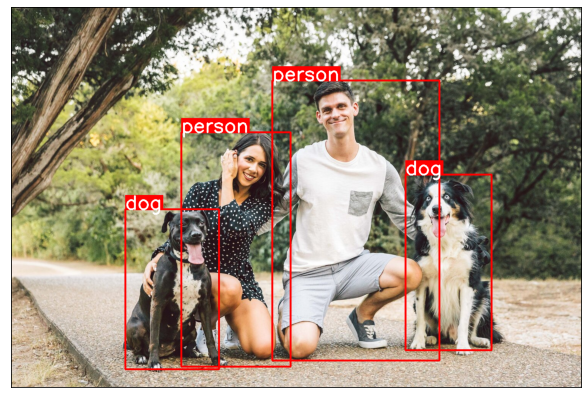

In [ ]:
img_numpy1, preds1 = get_predictions("./test1.jpg", model)
draw_bbox(img_numpy1, preds1)

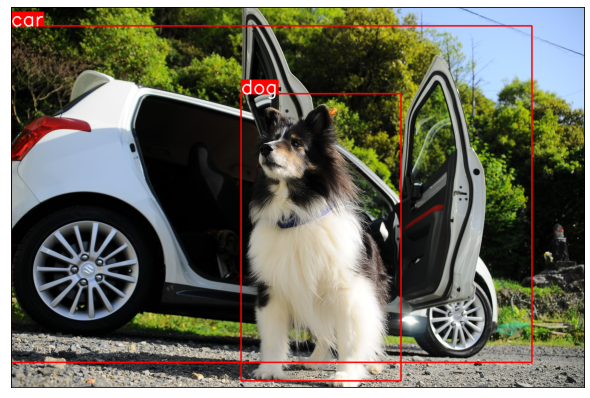

In [ ]:
img_numpy2, preds2 = get_predictions("./test2.jpg", model)
draw_bbox(img_numpy2, preds2)

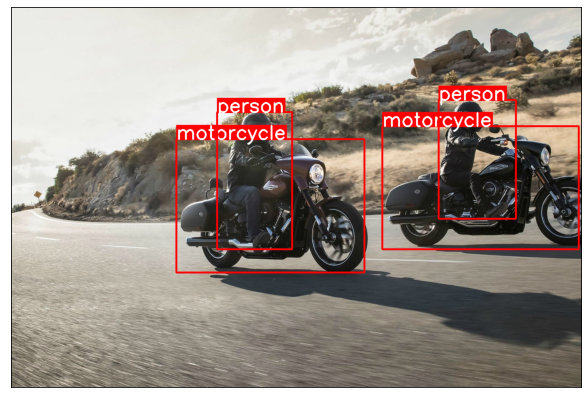

In [ ]:
img_numpy3, preds3 = get_predictions("./test3.jpg", model)
draw_bbox(img_numpy3, preds3)

## 3. Выбор фреймворка/библиотеки для разработки веб/мобильного демо
- Для разработки веб-демо используется фреймворк Flask.
- Для оформления визуальной части используется фреймворк Bootstrap.

## 4. Разработка демо
Код представлен в репозитории

## 5. Встраивание модели-детектора в демо
Код представлен в репозитории

## 6. Тестирование демо
Попробуем запустить приложение и посмотреть, как отрабатывает детектор на различных изображениях.

Воспользуемся библиотекой Requests для отправки POST-запросов к приложению. Чтобы отобразить результирующую html-страницу в Jupyter Notebook, используются возможности IPython

In [1]:
import requests
from IPython.display import display, HTML

Начнем тестирование с простых сцен: объекты расположены на одном уровне, не перекрывают друг друга, дневное освещение, изображения хорошего качества - детектор должен справиться с этой задачей.

In [2]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('people1.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

In [3]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('people2.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Как и предполагалось, проблем с детекцией объектов не возникло. Усложним задачу. Отправим изображение с объектами, которые находятся на разном расстоянии от фотографа

In [4]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('animals2.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

In [5]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('animals1.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Не все объекты на заднем плане были опознаны. Маленькие зебры затерялись на фоне больших, и детектор их не обнаружил. Возможно, если понизить порог уверенности bboxes, то у маленьких зебр есть шанс быть опознанными.

Кстати о зебрах

In [7]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('animals3.png', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Здесь проблем не возникло. Попробуем изображения с тенями

In [8]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('shadow1.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Детектор смог верно обнаружить только птиц (и то не всех). Льва нет в датасете CoCo, и он был перепутан с лошадью, а жираф и слон (с которыми детектор хорошо знаком) были проигнорированы. 

Посмотрим на другое изображение с тенями человека и собаки

In [9]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('shadow2.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Силуэт человека поддается распознаванию, с животными ситуация не складывается. Очевидно, стоит показать детектору больше подобных фото

Жираф с прошлой фотографии не был опознан, но что насчет Мелмана?

In [10]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('girafe.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Нетипичная для жирафа поза могла подпортить локализацию bbox'a, но в отличие от фотографии с тенью,  животное все-таки обнаружено. Видимо, в 2022 детектор все еще уделяет так много внимания цвету шерсти...

Теперь посмотрим на сложные городские сцены с присутствием большого количества объектов, которые могут перекрывать друг друга


In [13]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('city2.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Желтый автомобиль, "поделенный" пополам пешеходами, все-таки был обнаружен детектором, хоть и наполовину - передняя его часть осталась без внимания даже при наличии колеса. Синий автомобиль на заднем плане остался без внимания - опять проблема с отдаленными объектами

In [14]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('city3.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Данное фото достаточно сложное. Если уже не говорить о необнаруженных автомобилях на заднем плане, можно отметить, что без внимания также остался автобус справа и белый автомобиль за мотоциклом, а также сам мотоциклист. Все это можно объяснить перекрыванием объектов друг друга, что усложнило задачу детекции. Опять же возможно, что если понизить порог уверенности для отрисовки bounding boxes, данные объекты будут отмечены на фото

In [16]:
resp = requests.post("https://detectionproj.herokuapp.com/result", files={'file': open('city1.jpg', 'rb')})

if resp.ok:
  display(HTML(resp.text))

Одним из возможных решений проблемы может стать дообучение детектора на изображениях, где автомобиль представлен не полностью, а какой-то своей частью

## 7. Оформление демо для показа другим людям
Приложение загружено на платформу Heroku, ссылка в начале ноутбука